In [7]:
import sys,os,os.path
import math
import random
import matplotlib.pyplot as plt
import time
import glob 
import copy
import enum

import numpy as np
from PIL import Image
import torch.optim as optim

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import AdamW
import torchvision                  

import seaborn as sns
import pandas as pd
import gzip
import pickle

In [8]:
device=torch.device("cuda:0" if (torch.cuda.is_available()) else "cpu")

In [9]:
class SentimentAnalysisDataset(torch.utils.data.Dataset):
            def __init__(self, train_or_test, dataset_file, path_to_saved_embeddings=None):
                super(SentimentAnalysisDataset, self).__init__()
                import gensim.downloader as gen_api
#                self.word_vectors = gen_api.load("word2vec-google-news-300")
                self.path_to_saved_embeddings = path_to_saved_embeddings
                self.train_or_test = train_or_test
                root_dir = '/teamspace/studios/this_studio/Extra_Credit/data/'
                f = gzip.open(root_dir + dataset_file, 'rb')
                dataset = f.read()
                if path_to_saved_embeddings is not None:
                    import gensim.downloader as genapi
                    from gensim.models import KeyedVectors 
                    if os.path.exists(path_to_saved_embeddings + 'vectors.kv'):
                        self.word_vectors = KeyedVectors.load(path_to_saved_embeddings + 'vectors.kv')
                    else:
                        print("""\n\nSince this is your first time to install the word2vec embeddings, it may take"""
                              """\na couple of minutes. The embeddings occupy around 3.6GB of your disk space.\n\n""")
                        self.word_vectors = genapi.load("word2vec-google-news-300")               
                        ##  'kv' stands for  "KeyedVectors", a special datatype used by gensim because it 
                        ##  has a smaller footprint than dict
                        self.word_vectors.save(path_to_saved_embeddings + 'vectors.kv')    
                if train_or_test == 'train':
                    if sys.version_info[0] == 3:
                        self.positive_reviews_train, self.negative_reviews_train, self.vocab = pickle.loads(dataset, encoding='latin1')
                    else:
                        self.positive_reviews_train, self.negative_reviews_train, self.vocab = pickle.loads(dataset)
                    self.categories = sorted(list(self.positive_reviews_train.keys()))
                    self.category_sizes_train_pos = {category : len(self.positive_reviews_train[category]) for category in self.categories}
                    self.category_sizes_train_neg = {category : len(self.negative_reviews_train[category]) for category in self.categories}
                    self.indexed_dataset_train = []
                    for category in self.positive_reviews_train:
                        for review in self.positive_reviews_train[category]:
                            self.indexed_dataset_train.append([review, category, 1])
                    for category in self.negative_reviews_train:
                        for review in self.negative_reviews_train[category]:
                            self.indexed_dataset_train.append([review, category, 0])
                    random.shuffle(self.indexed_dataset_train)
                elif train_or_test == 'test':
                    if sys.version_info[0] == 3:
                        self.positive_reviews_test, self.negative_reviews_test, self.vocab = pickle.loads(dataset, encoding='latin1')
                    else:
                        self.positive_reviews_test, self.negative_reviews_test, self.vocab = pickle.loads(dataset)
                    self.vocab = sorted(self.vocab)
                    self.categories = sorted(list(self.positive_reviews_test.keys()))
                    self.category_sizes_test_pos = {category : len(self.positive_reviews_test[category]) for category in self.categories}
                    self.category_sizes_test_neg = {category : len(self.negative_reviews_test[category]) for category in self.categories}
                    self.indexed_dataset_test = []
                    for category in self.positive_reviews_test:
                        for review in self.positive_reviews_test[category]:
                            self.indexed_dataset_test.append([review, category, 1])
                    for category in self.negative_reviews_test:
                        for review in self.negative_reviews_test[category]:
                            self.indexed_dataset_test.append([review, category, 0])
                    random.shuffle(self.indexed_dataset_test)

            def review_to_tensor(self, review):
                list_of_embeddings = []
                for i,word in enumerate(review):
                    if word in self.word_vectors.key_to_index:
                        embedding = self.word_vectors[word]
                        list_of_embeddings.append(np.array(embedding))
                    else:
                        next
#                review_tensor = torch.FloatTensor( list_of_embeddings )
                review_tensor = torch.FloatTensor( np.array(list_of_embeddings) )
                return review_tensor

            def sentiment_to_tensor(self, sentiment):     
                sentiment_tensor = torch.zeros(2)
                if sentiment == 1:
                    sentiment_tensor[1] = 1
                elif sentiment == 0: 
                    sentiment_tensor[0] = 1
                sentiment_tensor = sentiment_tensor.type(torch.long)
                return sentiment_tensor

            def __len__(self):
                if self.train_or_test == 'train':
                    return len(self.indexed_dataset_train)
                elif self.train_or_test == 'test':
                    return len(self.indexed_dataset_test)

            def __getitem__(self, idx):
                sample = self.indexed_dataset_train[idx] if self.train_or_test == 'train' else self.indexed_dataset_test[idx]
                review = sample[0]
                review_category = sample[1]
                review_sentiment = sample[2]
                review_sentiment = self.sentiment_to_tensor(review_sentiment)
                review_tensor = self.review_to_tensor(review)
                category_index = self.categories.index(review_category)
                sample = {'review'       : review_tensor, 
                          'category'     : category_index, # should be converted to tensor, but not yet used
                          'sentiment'    : review_sentiment }
                return sample

In [4]:
dataroot = "/teamspace/studios/this_studio/Extra_Credit/data/"


dataset_archive_train = "sentiment_dataset_train_400.tar.gz"
#dataset_archive_train = "sentiment_dataset_train_200.tar.gz"

dataset_archive_test =  "sentiment_dataset_test_400.tar.gz"
#dataset_archive_test = "sentiment_dataset_test_200.tar.gz"

path_to_saved_embeddings = "/teamspace/studios/this_studio/Extra_Credit/data/word2vec/"
#path_to_saved_embeddings = "./data/TextDatasets/word2vec/"

dataserver_train = SentimentAnalysisDataset(
                                 train_or_test = 'train',
                                 dataset_file = dataset_archive_train,
                                 path_to_saved_embeddings = path_to_saved_embeddings,
                   )
dataserver_test = SentimentAnalysisDataset(
                                 train_or_test = 'test',
                                 dataset_file = dataset_archive_test,
                                 path_to_saved_embeddings = path_to_saved_embeddings,
                  )


In [11]:
y = dataserver_train[10]

In [13]:
y['review'][0].shape

torch.Size([300])

In [5]:
train_dataloader = torch.utils.data.DataLoader(dataserver_train,batch_size=1,shuffle=True)
test_dataloader = torch.utils.data.DataLoader(dataserver_test,batch_size=1,shuffle=False)

In [10]:
class GRUnet(nn.Module):

    def __init__(self, input_size, hidden_size, output_size, num_layers, drop_prob=0.2):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.gru = nn.GRU(input_size, hidden_size, num_layers)
        self.fc = nn.Linear(hidden_size, output_size)
        self.relu = nn.ReLU()
        self.logsoftmax = nn.LogSoftmax(dim=1)

    def forward(self, x, h):
        out, h = self.gru(x, h)
        out = self.fc(self.relu(out[:,-1]))
        out = self.logsoftmax(out)
        return out, h

    def init_hidden(self):
        weight = next(self.parameters()).data
        #                                     batch_size   
        hidden = weight.new(  self.num_layers,     1,         self.hidden_size   ).zero_()
        return hidden

In [11]:
class BiGRUnet(nn.Module):

    def __init__(self, input_size, hidden_size, output_size, num_layers, drop_prob=0.2):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.bidirectional = True
        
        self.gru = nn.GRU(input_size, hidden_size, num_layers, dropout=drop_prob, bidirectional=True)
        self.fc = nn.Linear(hidden_size * 2, output_size)  # Multiply by 2 for bidirectional
        self.relu = nn.ReLU()
        self.logsoftmax = nn.LogSoftmax(dim=1)

    def forward(self, x, h):
        out, h = self.gru(x, h)
        out = torch.cat((out[:, -1, :self.hidden_size], out[:, 0, self.hidden_size:]), dim=1)
        out = self.fc(self.relu(out))
        out = self.logsoftmax(out)
        return out, h

    def init_hidden(self, batch_size=1):
        weight = next(self.parameters()).data
        num_directions = 2 if self.bidirectional else 1
        hidden = weight.new(self.num_layers * num_directions, 1, self.hidden_size).zero_()
        return hidden

In [1]:
def run_code_for_training_with_GRU( net,train_dataloader,device, display_train_loss=True):        
    filename_for_out = "performance_numbers_" + str(1) + ".txt"
    FILE = open(filename_for_out, 'w')
    net.to(device)
    ## Note that the TEXTnet and TEXTnetOrder2 both produce LogSoftmax output:
    criterion = nn.NLLLoss()
    accum_times = []
    optimizer = optim.Adam(net.parameters(), lr=1e-4, betas = (0.8, 0.999))
    start_time = time.perf_counter()
    training_loss_tally = []
    for epoch in range(3):  
        print("")
        running_loss = 0.0
        for i, data in enumerate(train_dataloader):    
            hidden = net.init_hidden().to(device)     
            
            review_tensor,category,sentiment = data['review'], data['category'], data['sentiment']
            review_tensor = review_tensor.to(device)
            sentiment = sentiment.to(device)

            optimizer.zero_grad()
            hidden = net.init_hidden().to(device)
            for k in range(review_tensor.shape[1]):
               # input[0,:] = review_tensor[0,k]
                output, hidden = net(torch.unsqueeze(torch.unsqueeze(review_tensor[0,k],0),0), hidden)
            loss = criterion(output, torch.argmax(sentiment,1))
            running_loss += loss.item()
            loss.backward(retain_graph=True)        
            optimizer.step()

            if i % 200 == 199:    
                avg_loss = running_loss / float(200)
                training_loss_tally.append(avg_loss)
                current_time = time.perf_counter()
                time_elapsed = current_time-start_time
                print("[epoch:%d  iter:%4d  elapsed_time: %4d secs]     loss: %.5f" % (epoch+1,i+1, time_elapsed,avg_loss))
                accum_times.append(current_time-start_time)
                FILE.write("%.3f\n" % avg_loss)
                FILE.flush()
                running_loss = 0.0
    print("Total Training Time: {}".format(str(sum(accum_times))))
    print("\nFinished Training\n")
    torch.save(net.state_dict(), "/teamspace/studios/this_studio/Extra_Credit/data/unigru_EC_200.pt")
    if display_train_loss:
        plt.figure(figsize=(10,5))
        plt.title("Training Loss vs. Iterations for unidirectional GRU using word embeddings")
        plt.plot(training_loss_tally)
        plt.xlabel("iterations")
        plt.ylabel("training loss")
#                plt.legend()
        plt.legend(["Plot of loss versus iterations"], fontsize="x-large")
        plt.savefig("training_loss.png")
        plt.show()
    return training_loss_tally

In [2]:
def run_code_for_training_with_BiGRU( net,train_dataloader,device, display_train_loss=True):        
    filename_for_out = "performance_numbers_" + str(1) + ".txt"
    FILE = open(filename_for_out, 'w')
    net.to(device)
    ## Note that the TEXTnet and TEXTnetOrder2 both produce LogSoftmax output:
    criterion = nn.NLLLoss()
    accum_times = []
    optimizer = optim.Adam(net.parameters(), lr=1e-4, betas = (0.8, 0.999))
    start_time = time.perf_counter()
    training_loss_tally = []
    for epoch in range(3):  
        print("")
        running_loss = 0.0
        for i, data in enumerate(train_dataloader):    
                 
            
            review_tensor,category,sentiment = data['review'], data['category'], data['sentiment']
            review_tensor = review_tensor.to(device)
            sentiment = sentiment.to(device)

            optimizer.zero_grad()
            hidden = net.init_hidden().to(device)
            for k in range(review_tensor.shape[1]):
               # input[0,:] = review_tensor[0,k]
                output, hidden = net(torch.unsqueeze(torch.unsqueeze(review_tensor[0,k],0),0), hidden)
            loss = criterion(output, torch.argmax(sentiment,1))
            running_loss += loss.item()
            loss.backward(retain_graph=True)        
            optimizer.step()

            if i % 200 == 199:    
                avg_loss = running_loss / float(200)
                training_loss_tally.append(avg_loss)
                current_time = time.perf_counter()
                time_elapsed = current_time-start_time
                print("[epoch:%d  iter:%4d  elapsed_time: %4d secs]     loss: %.5f" % (epoch+1,i+1, time_elapsed,avg_loss))
                accum_times.append(current_time-start_time)
                FILE.write("%.3f\n" % avg_loss)
                FILE.flush()
                running_loss = 0.0
    print("Total Training Time: {}".format(str(sum(accum_times))))
    print("\nFinished Training\n")
    torch.save(net.state_dict(), "/teamspace/studios/this_studio/Extra_Credit/data/bigru_EC_200.pt")
    if display_train_loss:
        plt.figure(figsize=(10,5))
        plt.title("Training Loss vs. Iterations for unidirectional GRU using word embeddings")
        plt.plot(training_loss_tally)
        plt.xlabel("iterations")
        plt.ylabel("training loss")
#                plt.legend()
        plt.legend(["Plot of loss versus iterations"], fontsize="x-large")
        plt.savefig("training_loss.png")
        plt.show()
    return training_loss_tally

In [3]:
def run_code_for_testing_text_classification_with_GRU(net, test_dataloader, device, path):
    net.load_state_dict(torch.load(path))
    net.to(device)
    classification_accuracy = 0.0
    negative_total = 0
    positive_total = 0
    confusion_matrix = torch.zeros(2, 2)
    
    with torch.no_grad():
        for i, data in enumerate(test_dataloader):
            review_tensor,category,sentiment = data['review'], data['category'], data['sentiment']
            review_tensor = review_tensor.to(device)
            sentiment = sentiment.to(device)
            hidden = net.init_hidden().to(device)
            
            for k in range(review_tensor.shape[1]):
                output, hidden = net(torch.unsqueeze(torch.unsqueeze(review_tensor[0,k],0),0), hidden)
                
            predicted_idx = torch.argmax(output).item()
            gt_idx = torch.argmax(sentiment).item()
            if i % 100 == 99:
                print("   [i=%d]    predicted_label=%d       gt_label=%d\n\n" % (i+1, predicted_idx, gt_idx))
            
            if predicted_idx == gt_idx:
                classification_accuracy += 1
            
            if gt_idx == 0: 
                positive_total += 1
            elif gt_idx == 1:
                negative_total += 1
        
                
            confusion_matrix[gt_idx, predicted_idx] += 1
            
    classification_accuracy /= len(test_dataloader)
    print("\nOverall classification accuracy: %0.2f%%" % (classification_accuracy * 100))
    
    out_percent = np.zeros((2,2), dtype='float')
    out_percent[0,:] = 100 * confusion_matrix[0,:] / negative_total
    out_percent[1,:] = 100 * confusion_matrix[1,:] / positive_total
    
    print("\n\nNumber of negative reviews tested: %d" % negative_total)
    print("\nNumber of positive reviews tested: %d" % positive_total)
    
    print("\n\nDisplaying the confusion matrix:\n")


    plt.figure(figsize=(10, 7))
    sns.heatmap(confusion_matrix, annot=True, fmt='g', cmap='Blues', xticklabels=['positive', 'negative',],
                yticklabels=['positive', 'negative'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix for word embeddings for Bidirectional GRU')
    plt.show()

In [12]:
model_gru = GRUnet(300, hidden_size=100, output_size=2, num_layers=2)
device=torch.device("cuda:0" if (torch.cuda.is_available()) else "cpu")
number_of_learnable_params = sum(p.numel() for p in model_gru.parameters() if p.requires_grad)

num_layers = len(list(model_gru.parameters()))

print("\n\nThe number of layers in the model: %d" % num_layers)
print("\nThe number of learnable parameters in the model: %d" % number_of_learnable_params)



The number of layers in the model: 10

The number of learnable parameters in the model: 181402



[epoch:1  iter: 200  elapsed_time:    9 secs]     loss: 0.68724
[epoch:1  iter: 400  elapsed_time:   19 secs]     loss: 0.67903
[epoch:1  iter: 600  elapsed_time:   30 secs]     loss: 0.68211
[epoch:1  iter: 800  elapsed_time:   39 secs]     loss: 0.67807
[epoch:1  iter:1000  elapsed_time:   50 secs]     loss: 0.67149
[epoch:1  iter:1200  elapsed_time:   59 secs]     loss: 0.64739
[epoch:1  iter:1400  elapsed_time:   69 secs]     loss: 0.63839
[epoch:1  iter:1600  elapsed_time:   78 secs]     loss: 0.60989
[epoch:1  iter:1800  elapsed_time:   87 secs]     loss: 0.58093
[epoch:1  iter:2000  elapsed_time:   96 secs]     loss: 0.60309
[epoch:1  iter:2200  elapsed_time:  106 secs]     loss: 0.59360
[epoch:1  iter:2400  elapsed_time:  116 secs]     loss: 0.57740
[epoch:1  iter:2600  elapsed_time:  126 secs]     loss: 0.57355
[epoch:1  iter:2800  elapsed_time:  137 secs]     loss: 0.52613
[epoch:1  iter:3000  elapsed_time:  147 secs]     loss: 0.46839
[epoch:1  iter:3200  elapsed_time:  158

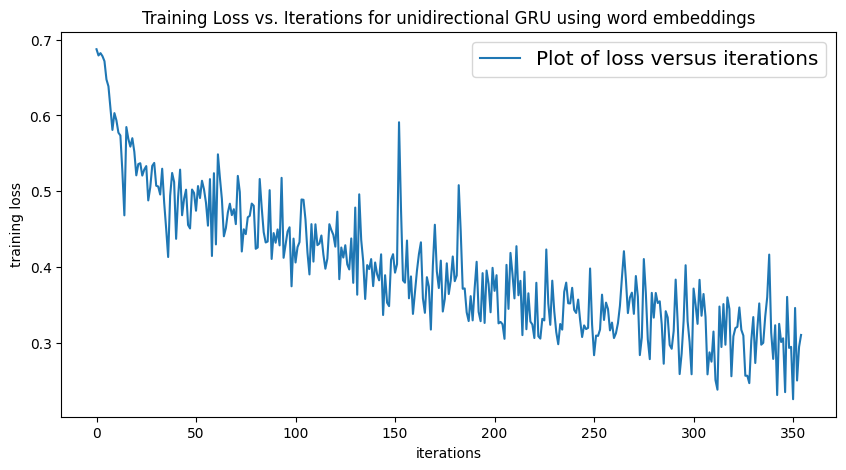

In [12]:
avg_loss_uni1_EC= run_code_for_training_with_GRU(net=model_gru,train_dataloader=train_dataloader, device=device, display_train_loss=True)

In [13]:
model_bigru = BiGRUnet(300, hidden_size=100, output_size=3, num_layers=3)
device=torch.device("cuda:0" if (torch.cuda.is_available()) else "cpu")
number_of_learnable_params = sum(p.numel() for p in model_bigru.parameters() if p.requires_grad)

num_layers = len(list(model_bigru.parameters()))

print("\n\nThe number of layers in the model: %d" % num_layers)
print("\nThe number of learnable parameters in the model: %d" % number_of_learnable_params)



The number of layers in the model: 26

The number of learnable parameters in the model: 604203



[epoch:1  iter: 200  elapsed_time:   19 secs]     loss: 0.82746
[epoch:1  iter: 400  elapsed_time:   37 secs]     loss: 0.71453
[epoch:1  iter: 600  elapsed_time:   56 secs]     loss: 0.68788
[epoch:1  iter: 800  elapsed_time:   74 secs]     loss: 0.70646
[epoch:1  iter:1000  elapsed_time:   89 secs]     loss: 0.69672
[epoch:1  iter:1200  elapsed_time:  109 secs]     loss: 0.67961
[epoch:1  iter:1400  elapsed_time:  127 secs]     loss: 0.68010
[epoch:1  iter:1600  elapsed_time:  144 secs]     loss: 0.66171
[epoch:1  iter:1800  elapsed_time:  164 secs]     loss: 0.61703
[epoch:1  iter:2000  elapsed_time:  182 secs]     loss: 0.64501
[epoch:1  iter:2200  elapsed_time:  202 secs]     loss: 0.59780
[epoch:1  iter:2400  elapsed_time:  217 secs]     loss: 0.62309
[epoch:1  iter:2600  elapsed_time:  236 secs]     loss: 0.60973
[epoch:1  iter:2800  elapsed_time:  255 secs]     loss: 0.61196
[epoch:1  iter:3000  elapsed_time:  272 secs]     loss: 0.59964
[epoch:1  iter:3200  elapsed_time:  290

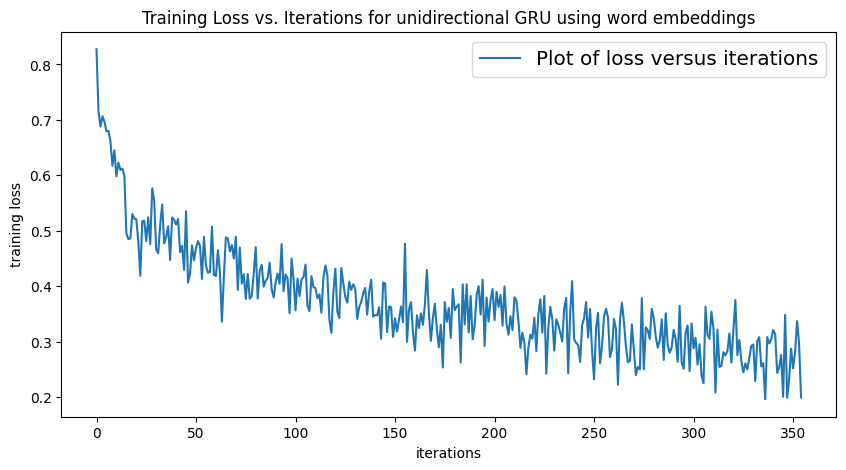

In [14]:
avg_loss_biuni1_EC= run_code_for_training_with_BiGRU(net=model_bigru,train_dataloader=train_dataloader, device=device, display_train_loss=True)

   [i=100]    predicted_label=1       gt_label=1


   [i=200]    predicted_label=0       gt_label=0


   [i=300]    predicted_label=0       gt_label=0


   [i=400]    predicted_label=1       gt_label=1


   [i=500]    predicted_label=0       gt_label=0


   [i=600]    predicted_label=0       gt_label=1


   [i=700]    predicted_label=0       gt_label=0


   [i=800]    predicted_label=0       gt_label=0


   [i=900]    predicted_label=1       gt_label=1


   [i=1000]    predicted_label=1       gt_label=0


   [i=1100]    predicted_label=0       gt_label=0


   [i=1200]    predicted_label=1       gt_label=1


   [i=1300]    predicted_label=0       gt_label=0


   [i=1400]    predicted_label=1       gt_label=0


   [i=1500]    predicted_label=1       gt_label=1


   [i=1600]    predicted_label=1       gt_label=1


   [i=1700]    predicted_label=1       gt_label=0


   [i=1800]    predicted_label=1       gt_label=1


   [i=1900]    predicted_label=0       gt_label=0


   [i=2000]    predic

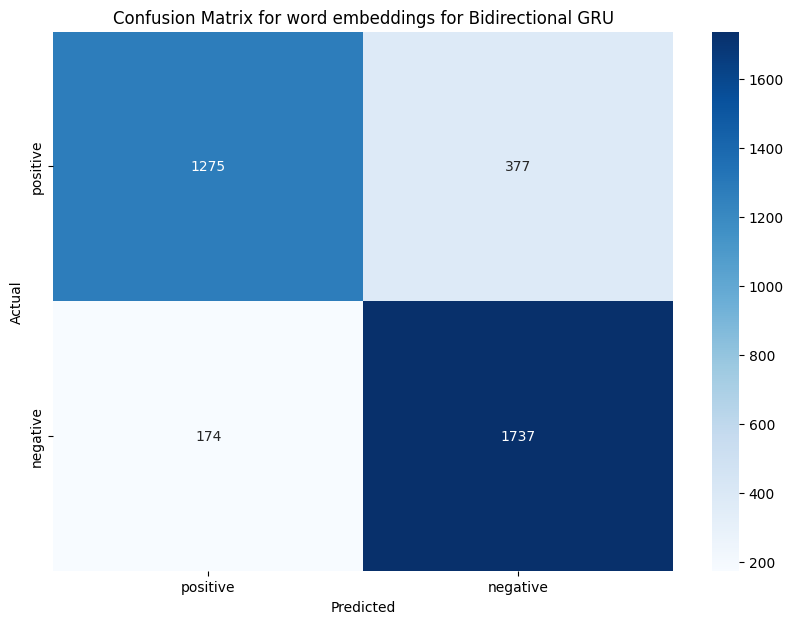

In [19]:
run_code_for_testing_text_classification_with_GRU(net=model_gru,test_dataloader=test_dataloader, device=device, path='/teamspace/studios/this_studio/Extra_Credit/data/unigru_EC.pt')

   [i=100]    predicted_label=1       gt_label=1


   [i=200]    predicted_label=0       gt_label=0


   [i=300]    predicted_label=0       gt_label=0


   [i=400]    predicted_label=1       gt_label=1


   [i=500]    predicted_label=0       gt_label=0


   [i=600]    predicted_label=0       gt_label=1


   [i=700]    predicted_label=0       gt_label=0


   [i=800]    predicted_label=0       gt_label=0


   [i=900]    predicted_label=0       gt_label=1


   [i=1000]    predicted_label=0       gt_label=0


   [i=1100]    predicted_label=0       gt_label=0


   [i=1200]    predicted_label=1       gt_label=1


   [i=1300]    predicted_label=0       gt_label=0


   [i=1400]    predicted_label=0       gt_label=0


   [i=1500]    predicted_label=1       gt_label=1


   [i=1600]    predicted_label=1       gt_label=1


   [i=1700]    predicted_label=1       gt_label=0


   [i=1800]    predicted_label=1       gt_label=1


   [i=1900]    predicted_label=0       gt_label=0


   [i=2000]    predic

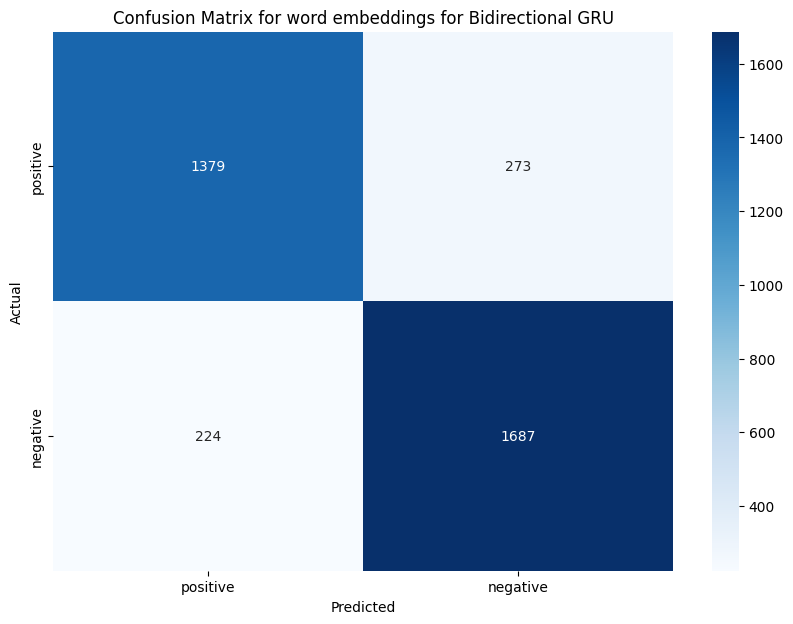

In [20]:
run_code_for_testing_text_classification_with_GRU(net=model_bigru,test_dataloader=test_dataloader, device=device, path='/teamspace/studios/this_studio/Extra_Credit/data/bigru_EC.pt')

In [14]:
dataroot = "/teamspace/studios/this_studio/Extra_Credit/data/"


dataset_archive_train_200 = "sentiment_dataset_train_200.tar.gz"
#dataset_archive_train = "sentiment_dataset_train_200.tar.gz"

dataset_archive_test_200 =  "sentiment_dataset_test_200.tar.gz"
#dataset_archive_test = "sentiment_dataset_test_200.tar.gz"

path_to_saved_embeddings = "/teamspace/studios/this_studio/Extra_Credit/data/word2vec/"
#path_to_saved_embeddings = "./data/TextDatasets/word2vec/"

dataserver_train_200 = SentimentAnalysisDataset(
                                 train_or_test = 'train',
                                 dataset_file = dataset_archive_train_200,
                                 path_to_saved_embeddings = path_to_saved_embeddings,
                   )
dataserver_test_200 = SentimentAnalysisDataset(
                                 train_or_test = 'test',
                                 dataset_file = dataset_archive_test_200,
                                 path_to_saved_embeddings = path_to_saved_embeddings,
                  )

In [15]:
train_dataloader_200 = torch.utils.data.DataLoader(dataserver_train_200,batch_size=1,shuffle=True)
test_dataloader_200 = torch.utils.data.DataLoader(dataserver_test_200,batch_size=1,shuffle=False)


[epoch:1  iter: 200  elapsed_time:   10 secs]     loss: 0.69565
[epoch:1  iter: 400  elapsed_time:   20 secs]     loss: 0.69227
[epoch:1  iter: 600  elapsed_time:   31 secs]     loss: 0.68801
[epoch:1  iter: 800  elapsed_time:   41 secs]     loss: 0.68741
[epoch:1  iter:1000  elapsed_time:   52 secs]     loss: 0.68717
[epoch:1  iter:1200  elapsed_time:   62 secs]     loss: 0.68013
[epoch:1  iter:1400  elapsed_time:   73 secs]     loss: 0.67004
[epoch:1  iter:1600  elapsed_time:   85 secs]     loss: 0.63493
[epoch:1  iter:1800  elapsed_time:   95 secs]     loss: 0.61970
[epoch:1  iter:2000  elapsed_time:  105 secs]     loss: 0.59728
[epoch:1  iter:2200  elapsed_time:  115 secs]     loss: 0.52499
[epoch:1  iter:2400  elapsed_time:  125 secs]     loss: 0.54844
[epoch:1  iter:2600  elapsed_time:  134 secs]     loss: 0.64245
[epoch:1  iter:2800  elapsed_time:  145 secs]     loss: 0.56971
[epoch:1  iter:3000  elapsed_time:  155 secs]     loss: 0.57395
[epoch:1  iter:3200  elapsed_time:  166

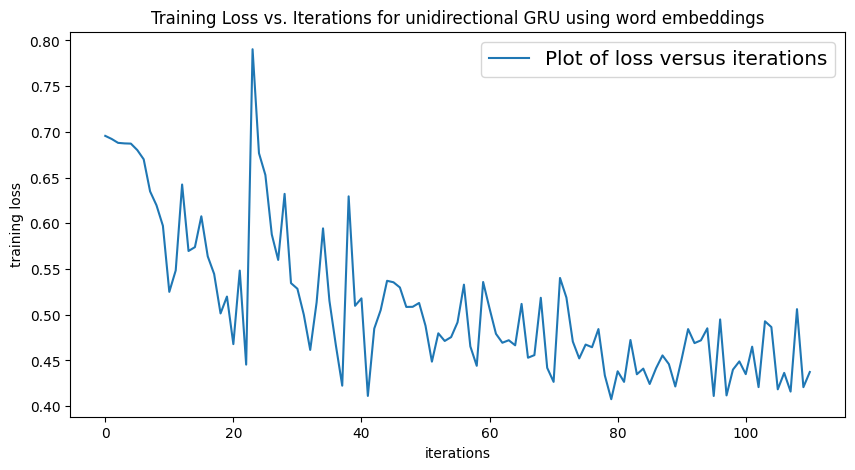

In [16]:
avg_loss_uni1_EC_200= run_code_for_training_with_GRU(net=model_gru,train_dataloader=train_dataloader_200, device=device, display_train_loss=True)


[epoch:1  iter: 200  elapsed_time:   17 secs]     loss: 0.83734
[epoch:1  iter: 400  elapsed_time:   38 secs]     loss: 0.71614
[epoch:1  iter: 600  elapsed_time:   56 secs]     loss: 0.70824
[epoch:1  iter: 800  elapsed_time:   73 secs]     loss: 0.69269
[epoch:1  iter:1000  elapsed_time:   91 secs]     loss: 0.70146
[epoch:1  iter:1200  elapsed_time:  108 secs]     loss: 0.69061
[epoch:1  iter:1400  elapsed_time:  128 secs]     loss: 0.69202
[epoch:1  iter:1600  elapsed_time:  146 secs]     loss: 0.69019
[epoch:1  iter:1800  elapsed_time:  166 secs]     loss: 0.65782
[epoch:1  iter:2000  elapsed_time:  184 secs]     loss: 0.66012
[epoch:1  iter:2200  elapsed_time:  201 secs]     loss: 0.56898
[epoch:1  iter:2400  elapsed_time:  220 secs]     loss: 0.59082
[epoch:1  iter:2600  elapsed_time:  242 secs]     loss: 0.64123
[epoch:1  iter:2800  elapsed_time:  261 secs]     loss: 0.59621
[epoch:1  iter:3000  elapsed_time:  278 secs]     loss: 0.57936
[epoch:1  iter:3200  elapsed_time:  298

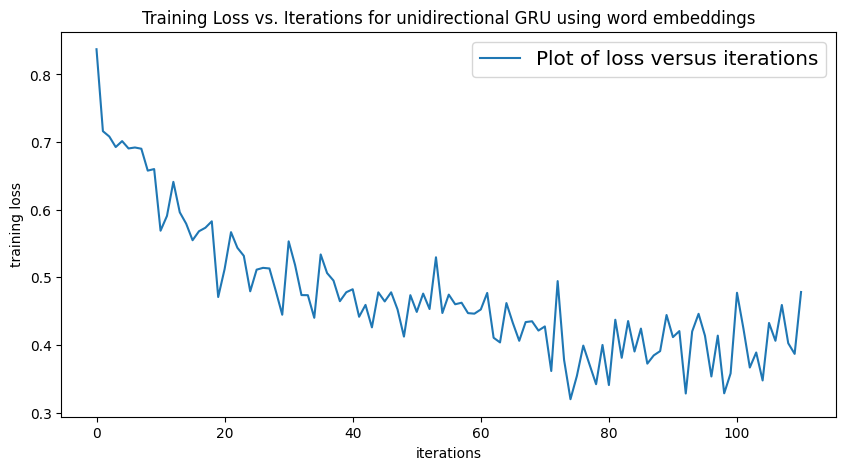

In [17]:
avg_loss_biuni1_EC_200= run_code_for_training_with_BiGRU(net=model_bigru,train_dataloader=train_dataloader_200, device=device, display_train_loss=True)

   [i=100]    predicted_label=0       gt_label=0


   [i=200]    predicted_label=1       gt_label=1


   [i=300]    predicted_label=1       gt_label=0


   [i=400]    predicted_label=1       gt_label=1


   [i=500]    predicted_label=0       gt_label=0


   [i=600]    predicted_label=1       gt_label=1


   [i=700]    predicted_label=1       gt_label=1


   [i=800]    predicted_label=1       gt_label=1


   [i=900]    predicted_label=0       gt_label=0


   [i=1000]    predicted_label=0       gt_label=0


   [i=1100]    predicted_label=1       gt_label=0


   [i=1200]    predicted_label=1       gt_label=0


   [i=1300]    predicted_label=0       gt_label=0


   [i=1400]    predicted_label=1       gt_label=1


   [i=1500]    predicted_label=0       gt_label=1


   [i=1600]    predicted_label=0       gt_label=0


   [i=1700]    predicted_label=1       gt_label=1


   [i=1800]    predicted_label=1       gt_label=1



Overall classification accuracy: 81.67%


Number of negative reviews tes

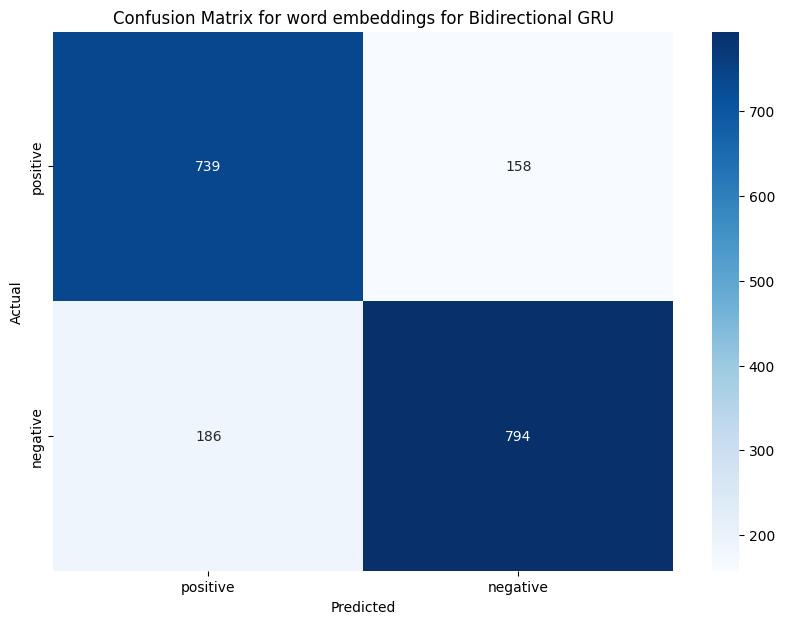

In [18]:
run_code_for_testing_text_classification_with_GRU(net=model_gru,test_dataloader=test_dataloader_200, device=device, path='/teamspace/studios/this_studio/Extra_Credit/data/unigru_EC_200.pt')

   [i=100]    predicted_label=0       gt_label=0


   [i=200]    predicted_label=0       gt_label=1


   [i=300]    predicted_label=0       gt_label=0


   [i=400]    predicted_label=1       gt_label=1


   [i=500]    predicted_label=0       gt_label=0


   [i=600]    predicted_label=1       gt_label=1


   [i=700]    predicted_label=1       gt_label=1


   [i=800]    predicted_label=1       gt_label=1


   [i=900]    predicted_label=0       gt_label=0


   [i=1000]    predicted_label=0       gt_label=0


   [i=1100]    predicted_label=1       gt_label=0


   [i=1200]    predicted_label=0       gt_label=0


   [i=1300]    predicted_label=0       gt_label=0


   [i=1400]    predicted_label=1       gt_label=1


   [i=1500]    predicted_label=0       gt_label=1


   [i=1600]    predicted_label=0       gt_label=0


   [i=1700]    predicted_label=1       gt_label=1


   [i=1800]    predicted_label=1       gt_label=1



Overall classification accuracy: 76.35%


Number of negative reviews tes

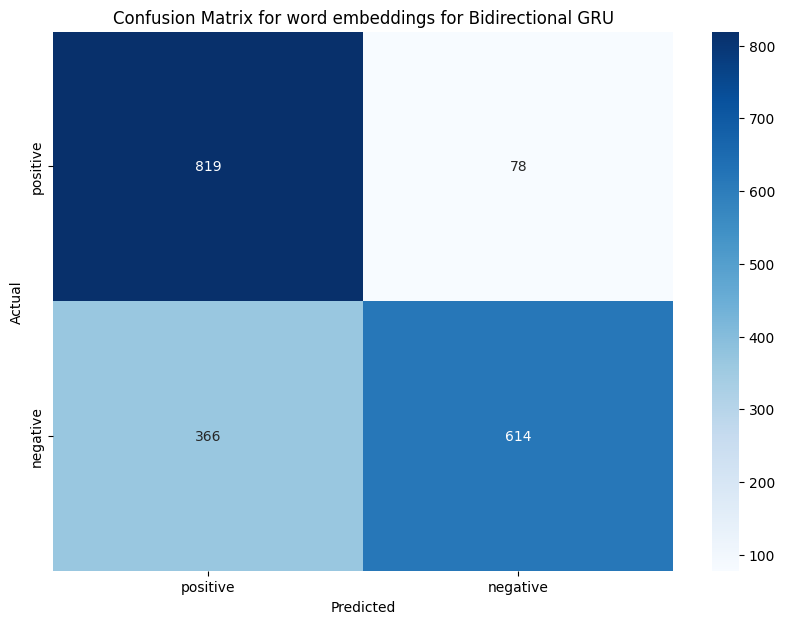

In [19]:
run_code_for_testing_text_classification_with_GRU(net=model_bigru,test_dataloader=test_dataloader_200, device=device, path='/teamspace/studios/this_studio/Extra_Credit/data/bigru_EC_200.pt')